Import the libraries necessary to analize data

In [64]:
%matplotlib inline
import math
import numpy as np
import pandas as pd
import scipy.stats as stats
import matplotlib.pyplot as plt
import datetime
import random
import seaborn as sns
import plotly.express as px

from collections import defaultdict
from scipy.stats import pearsonr
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler, MinMaxScaler

In [65]:
df = pd.read_csv('../TASK1/df_after_dp.csv', parse_dates=['date'])
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 166664 entries, 0 to 166663
Data columns (total 31 columns):
 #   Column                     Non-Null Count   Dtype         
---  ------                     --------------   -----         
 0   date                       166664 non-null  datetime64[ns]
 1   state                      166664 non-null  object        
 2   city_or_county             166664 non-null  object        
 3   latitude                   166664 non-null  float64       
 4   longitude                  166664 non-null  float64       
 5   congressional_district     166664 non-null  int64         
 6   avg_age_participants       166664 non-null  float64       
 7   n_participants_child       166664 non-null  int64         
 8   n_participants_teen        166664 non-null  int64         
 9   n_females                  166664 non-null  float64       
 10  n_killed                   166664 non-null  float64       
 11  n_injured                  166664 non-null  float64 

Since in the TASK 3, we need to define a boolean variable representing the class, we decide to pre-calculate it together also with other classes involving injury to label the PCA results after the scaling and see how they are distributed

In [66]:
df['isKilled'] = np.where(df['n_killed'] > 0, 1, 0) 
df['involve_injury'] = np.where(df['n_injured'] > 0, 1, 0) 

Since we use distance metric working on numerical features we remove the categorical data and useless features. 

N.B. We will use **only indicators** for the clustering

In [67]:
column_to_drop = ['avg_age_participants','n_participants','n_participants_child', 'n_participants_teen', 'n_females', 'n_killed', 'n_injured',
       'n_arrested', 'n_unharmed','date', 'latitude', 'longitude','congressional_district', 'candidatevotes', 'totalvotes', 'isKilled', 'involve_injury'
       ]
for col in df.columns:
    if df[col].dtype == 'object':
       column_to_drop.append(col)

In [68]:
numeric_attributes = [item for item in df.columns if item not in column_to_drop]
numeric_attributes

['povertyPercentage',
 'incident_gravity',
 'females_rate',
 'minor_rate',
 'arrested_rate',
 'survival_rate',
 'winning_party_percentage',
 'killed_rate',
 'injured_rate',
 'killed_disp_per_district',
 'injured_disp_per_district',
 'part_disp_per_district']

In [70]:
df_numeric = df.drop(columns=column_to_drop)
df_numeric.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 166664 entries, 0 to 166663
Data columns (total 12 columns):
 #   Column                     Non-Null Count   Dtype  
---  ------                     --------------   -----  
 0   povertyPercentage          166664 non-null  float64
 1   incident_gravity           166664 non-null  float64
 2   females_rate               166664 non-null  float64
 3   minor_rate                 166664 non-null  float64
 4   arrested_rate              166664 non-null  float64
 5   survival_rate              166664 non-null  float64
 6   winning_party_percentage   166664 non-null  float64
 7   killed_rate                166664 non-null  float64
 8   injured_rate               166664 non-null  float64
 9   killed_disp_per_district   166664 non-null  float64
 10  injured_disp_per_district  166664 non-null  float64
 11  part_disp_per_district     166664 non-null  float64
dtypes: float64(12)
memory usage: 15.3 MB


## Normalization

A good practice is to scale data to avoid that some features dominates the others in the clustering, so we done it

In [71]:
scaler = StandardScaler()
X = scaler.fit_transform(df_numeric.values)
scaled_df = pd.DataFrame(X, columns=df_numeric.columns)

## PCA

We do the PCA analysis to visualize in 2D the distribution of our multi-dimensional data

In [72]:
scaled_df[column_to_drop] = df[column_to_drop]

In [73]:
pca = PCA(n_components=2)

In [74]:
scaled_df[['pc1','pc2']] = pca.fit_transform(scaled_df[numeric_attributes])

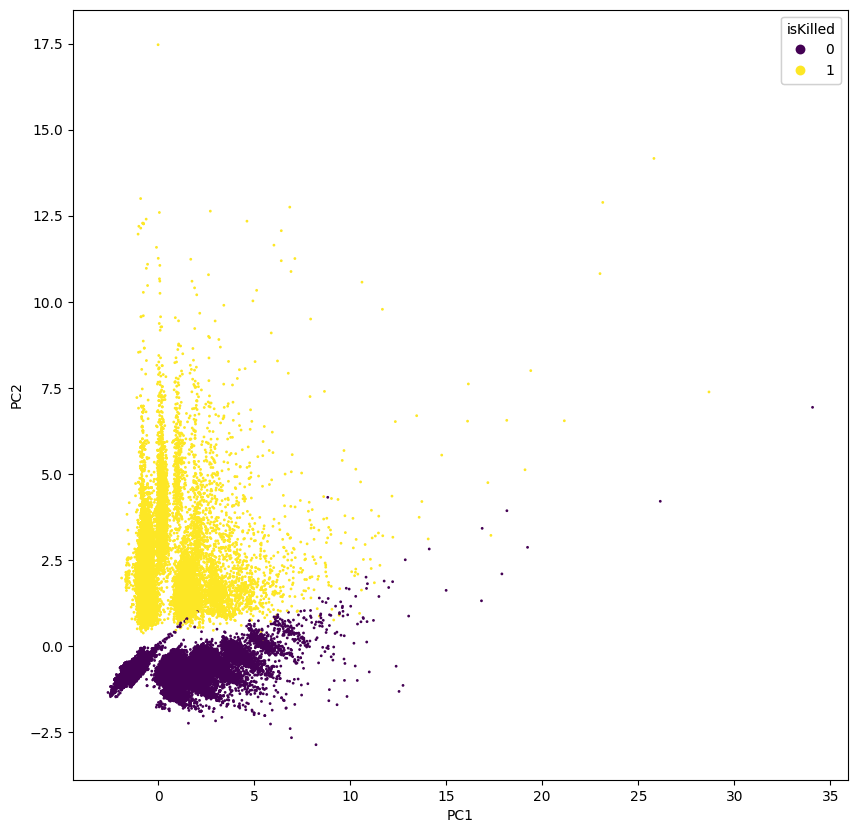

In [75]:
plt.figure(figsize=(10,10))
scatter = plt.scatter(scaled_df['pc1'], scaled_df['pc2'],  c=scaled_df['isKilled'], s=1) #c=scaled_df['party'].replace(dict(zip(scaled_df['party'].unique(), range(len(scaled_df['party'].unique())))))

# create a new legend with the state names and colors
plt.xlabel('PC1')
plt.ylabel('PC2')


legend1 = plt.legend(*scatter.legend_elements(), title="isKilled")
plt.gca().add_artist(legend1)
# display the plot
plt.show()

0 stands for isKilled = false and
1 stands for isKilled = true

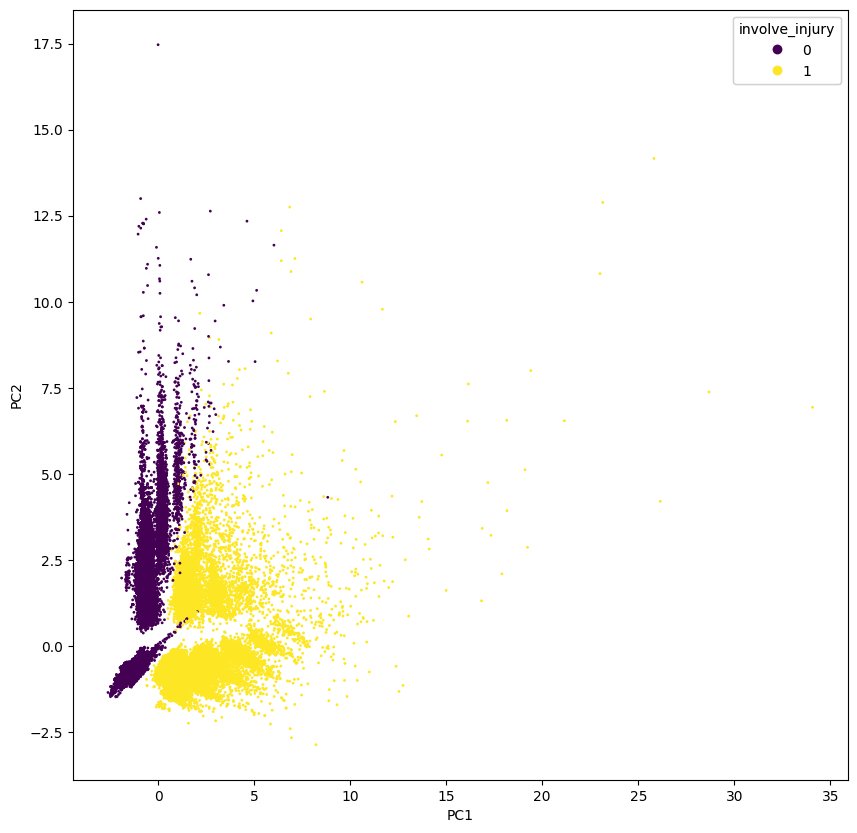

In [76]:
plt.figure(figsize=(10,10))
plt.scatter(scaled_df['pc1'], scaled_df['pc2'],  c=scaled_df['involve_injury'], s=1) #c=scaled_df['party'].replace(dict(zip(scaled_df['party'].unique(), range(len(scaled_df['party'].unique())))))
# get the handles and labels of the legend
#handles, labels = plt.gca().get_legend_handles_labels()
plt.xlabel('PC1')
plt.ylabel('PC2')


legend1 = plt.legend(*scatter.legend_elements(), title="involve_injury")
plt.gca().add_artist(legend1)

# display the plot
plt.show()

0 stands for involve_injury = false and
1 stands for involve_injury = true

As we can see there are more or less four clusters resulting for the PCA, so it make sense to perform clustering.

## Saving the normalized dataset

In [77]:
scaled_df.to_csv('df_scaled.csv', index=False)